$y_i = \alpha + \beta_1 \cdot x_{i1} + \beta_2 \cdot x_{i2} + ... + \beta_k \cdot x_{ik} + \varepsilon_i$

~~~
beta = [alpha, beta_1, ..., beta_k]
~~~

~~~
x_i = [1, x_i1, ..., x_ik]
~~~

In [1]:
def dot(v, w):
    """
    v_1 * w_1 + ... + v_n * w_n
    """
    return sum(v_i * w_i 
               for v_i, w_i in zip(v, w))

def predict(x_i, beta):
    """
    assumes that the first element of each x_i is 1
    """
    return dot(x_i, beta)

#### Further Assumptions of the Least Squares Model

"There are a couple of further assumptions that are required for this model (and our solution) to make sense."
* "The first is that the columns of x are linearly independent—that there’s no way to write any one as a weighted sum of some of the others. If this assumption fails, it’s impossible to estimate beta."

* "The second important assumption is that the columns of x are all uncorrelated with the errors ε . If this fails to be the case, our estimates of beta will be systematically wrong."

#### Fitting the model

In [2]:
def error(x_i, y_i, beta):
    return y_i - predict(x_i, beta)

def squared_error(x_i, y_i, beta):
    return error(x_i, y_i, beta) ** 2

In [3]:
def squared_error_gradient(x_i, y_i, beta):
    """
    the gradient (with respect to beta)
    corresponding to the ith squared error term
    """
    return [-2 * x_ij * error(x_i, y_i, beta) 
            for x_ij in x_i]

In [4]:
def estimate_beta(x, y):
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(squared_error,
                               squared_error_gradient,x,y,
                               beta_initial,0.001)

#### Interpreting the model

- "You should think of the coefficients of the model as representing all-else-being-equal estimates of the impacts of each factor."

- "What this doesn’t (directly) tell us is anything about the interactions among the variables."

#### Goodness of Fit

In [5]:
def multiple_r_squared(x, y, beta):
    sum_of_squared_errors = sum(error(x_i, y_i, beta) ** 2 
                                for x_i, y_i in zip(x, y))

    return 1.0 - sum_of_squared_errors / total_sum_of_squares(y)

"**Keep in mind, however, that adding new variables to a regression will necessarily increase the R-squared.**"

- "After all, the simple regression model is just the special case of the multiple regression model".
- "The optimal multiple regression model will necessarily have an error at least as small as that one."

"Because of this, in a multiple regression, we also need to look at the *standard errors* of the coefficients, which measure how certain we are about our estimates of each $\beta_i$."

- "The regression as a whole may fit our data very well, but if some of the independent variables are correlated (or irrelevant), their coefficients might not mean much."

"The typical approach to measuring these errors starts with another assumption—that the errors ε i are independent normal random variables with mean 0 and some shared (unknown) standard deviation σ ."

- "In that case, we can use some linear algebra to find the standard error of each coefficient. The larger it is, the less sure our model is about that coefficient."

#### Digression: The Bootstrap ####

In [8]:
import random

def bootstrap_sample(data):
    """
    randomly samples len(data) elements with replacement
    """
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data, stats_fn, num_samples):
    """
    evaluates stats_fn on num_samples bootstrap samples from data
    """
    return [stats_fn(bootstrap_sample(data)) 
            for _ in range(num_samples)]

In [11]:
def median(v):
    """
    finds the 'middle-most' value of v
    """
    n = len(v)
    sorted_v = sorted(v)
    midpoint = n // 2
    if n % 2 == 1:
        # if odd, return the middle value
        return sorted_v[midpoint]
    else:
        # if even, return the average of the middle values
        lo = midpoint - 1
        hi = midpoint
        return (sorted_v[lo] + sorted_v[hi]) / 2

In [12]:
# 101 points all very close to 100
close_to_100 = [99.5 + random.random() for _ in range(101)]

# 101 points, 50 of them near 0, 50 of them near 200
far_from_100 = ([99.5 + random.random()] + 
                [random.random() for _ in range(50)] + 
                [200 + random.random() for _ in range(50)])

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

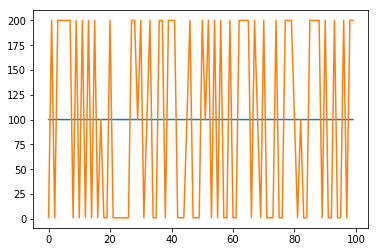

In [16]:
plt.plot(bootstrap_statistic(close_to_100, median, 100),label='close')
plt.plot(bootstrap_statistic(far_from_100, median, 100),label='far')

#### Standard Errors of Regression Coefficients

"We can take the same approach to estimating the standard errors of our regression coefficients. We repeatedly take a bootstrap_sample of our data and estimate beta based on that sample."

- "If the coefficient corresponding to one of the independent variables doesn’t vary much across samples, then we can be confident that our estimate is relatively tight."
- "If the coefficient varies greatly across samples, then we can’t be at all confident in our estimate."

"**The only subtlety is that, before sampling, we’ll need to zip our x data and y data to make sure that corresponding values of the independent and dependent variables are sampled together.**"

- "This means that bootstrap_sample will return a list of pairs ($x_i$,$y_i$), which we’ll need to reassemble into an x_sample and a y_sample :"

In [17]:
def estimate_sample_beta(sample):
    """
    sample is a list of pairs (x_i, y_i)
    """
    x_sample, y_sample = zip(*sample) # magic unzipping trick
    return estimate_beta(x_sample, y_sample)

~~~
random.seed(0) # so that you get the same results as me
bootstrap_betas = bootstrap_statistic(zip(x,daily_minutes_good),
                                        estimate_sample_beta,
                                        100)
bootstrap_standard_errors = [standard_deviation([beta[i] 
                                for beta in bootstrap_betas])
                                for i in range(4)]
~~~

#### Regularization

"In practice, you’d often like to apply linear regression to data sets with large numbers of variables. This creates a couple of extra wrinkles."

- "First, the more variables you use, the more likely you are to overfit your model to the training set."
- "And second, the more nonzero coefficients you have, the harder it is to make sense of them."

"**If the goal is to explain some phenomenon, a sparse model with three factors might be more useful than a slightly better model with hundreds.**"

**Regularization**: "an approach in which we add to the error term a penalty that gets larger as beta gets larger. We then minimize the combined error and penalty. The more importance we place on the penalty term, the more we discourage large coefficients.

##### Ridge Regression #####

"\[W\]e add a penalty proportional to the sum of the squares of the beta_i . (Except that typically we don’t penalize beta_0 , the constant term.)"

In [19]:
# alpha is a *hyperparameter* controlling how harsh the penalty is
# sometimes it's called "lambda" but that already means something in Python
def ridge_penalty(beta, alpha):
    return alpha * dot(beta[1:], beta[1:])

def squared_error_ridge(x_i, y_i, beta, alpha):
    """
    estimate error plus ridge penalty on beta
    """
    return error(x_i, y_i, beta) ** 2 + ridge_penalty(beta, alpha)

In [21]:
def ridge_penalty_gradient(beta, alpha):
    """
    gradient of just the ridge penalty
    """
    return [0] + [2 * alpha * beta_j for beta_j in beta[1:]]

def squared_error_ridge_gradient(x_i, y_i, beta, alpha):
    """
    the gradient corresponding to the ith squared error term
    including the ridge penalty
    """
    return vector_add(squared_error_gradient(x_i, y_i, beta),
                      ridge_penalty_gradient(beta, alpha))

def estimate_beta_ridge(x, y, alpha):
    """
    use gradient descent to fit a ridge regression
    with penalty alpha
    """
    beta_initial = [random.random() for x_i in x[0]]
    return minimize_stochastic(partial(squared_error_ridge, alpha=alpha),
                               partial(squared_error_ridge_gradient,alpha=alpha),
                               x, y,beta_initial,0.001)


"**Usually you’d want to rescale your data before using this approach. After all, if you changed years of experience to centuries
of experience, its least squares coefficient would increase by a factor of 100 and suddenly get penalized much more, even though it’s
the same model.**"

##### Lasso Regression #####

In [22]:
def lasso_penalty(beta, alpha):
    return alpha * sum(abs(beta_i) for beta_i in beta[1:])

"Whereas the ridge penalty shrank the coefficients overall, the lasso penalty tends to force coefficients to be zero, which makes it good for learning sparse models."

- "\[...\] it’s not amenable to gradient descent".